In [43]:
import os
import time
from PIL import Image
import requests
import math
from io import BytesIO
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from dotenv import load_dotenv
import json

import azure.ai.vision as sdk
import pandas as pd
import numpy as np
from tenacity import retry, stop_after_attempt, wait_random_exponential

In [2]:
load_dotenv('../.env')

# Azure Computer Vision
key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

In [55]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def get_embedding(imagefile):
    """
    Get embedding from an image using Azure Computer Vision 4
    """

    # settings
    options = "&features=caption,tags"
    model = "?api-version=2023-02-01-preview&modelVersion=latest"
    url = endpoint + "/computervision/retrieval:vectorizeImage" + model # + options
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": key,
    }

    # Read the image file
    with open(imagefile, "rb") as f:
        data = f.read()

    # Sending the requests
    r = requests.post(url, data=data, headers=headers)
    results = r.json()
    embeddings = results['vector']

    return embeddings

def get_text_embedding(text):
    """
    Get embedding from text using Azure Computer Vision 4
    """

    # settings
    options = "&features=caption,tags"
    model = "?api-version=2023-02-01-preview&modelVersion=latest"
    url = endpoint + "/computervision/retrieval:vectorizeText" + model # + options
    headers = {
        "Content-type": "application/json",
        "Ocp-Apim-Subscription-Key": key,
    }

    data = {
        "text": text
    }

    # Sending the requests
    r = requests.post(url, data=json.dumps(data), headers=headers)
    results = r.json()
    embeddings = results['vector']

    return embeddings

get_text_embedding('cat jumping')

import math

def get_cosine_similarity(vector1, vector2):
    dot_product = sum(a*b for a, b in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum((val*val) for val in vector1))
    magnitude2 = math.sqrt(sum((val*val) for val in vector2))
    return dot_product / (magnitude1 * magnitude2)

def show_images(images, cols=2, source='url', savedir=''):
    """
    Get images from URL and display them in a grid. Optionally save or retrieve images to/from local dir. 
    
    Parameters
    ----------
    images : list
        List of image urls or local file paths.
    cols : int
        Number of columns in the grid.
    source : str
        'url' or 'local'
    savedir : str
        Directory to save images to.
    """
    
    if savedir != '':
        os.makedirs(savedir, exist_ok=True)
        
    rows = int(math.ceil(len(images) / cols))

    fig = plt.figure(figsize=(cols * 5, rows * 5)) # specifying the overall grid size

    for i, image_url in enumerate(images):
        plt.subplot(rows, cols,i+1)  
        
        if source == 'url':
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))
            
            # save images if savedir is specified
            if savedir != '':
                
                # get list of png files
                png_filenames = [image for image in os.listdir(savedir) if image.endswith('.png')]
                # get highest index from existing files
                if png_filenames == []:
                    max_index = 0
                else:
                    max_index = max([int(filename.strip('.png')) for filename in png_filenames])

                # save new file with index + 1
                new_filename = f'{max_index+1:03d}.png'
                fp = os.path.join(savedir, new_filename)
                img.save(fp, 'PNG')            
            
        else: 
            img = Image.open(image_url) # local file
            plt.title(image_url)

        plt.imshow(img)
        plt.axis('off')

    fig.tight_layout()

    plt.show()


In [ ]:
image_root = './source/'

df = pd.DataFrame(columns=['file', 'class', 'embedding'])

idx = 0
for root, dirs, files in os.walk(image_root):
    for dir in dirs:
        print(f"Subfolder: {dir}")
        subdir = os.path.join(root, dir)
        for file in os.listdir(subdir):
            if file.endswith('.png') or file.endswith('.jpg'):
                print(f"Image file: {file}")
                full_path = os.path.join(image_root, dir, file)

                embedding = get_embedding(imagefile=full_path)

                row = [full_path, dir, embedding]
                df.loc[idx] = row
                idx += 1

In [33]:
df

,file,class,embedding
0,./source/animals/Picture195.jpg,animals,"[-2.9765625, 0.6513672, 0.8491211, -0.72265625..."
1,./source/animals/Picture168.jpg,animals,"[-1.6015625, -2.3242188, -0.16601562, -0.05276..."
2,./source/animals/Picture160.jpg,animals,"[-0.70703125, -0.4416504, 2.6035156, -3.78125,..."
3,./source/animals/Picture183.jpg,animals,"[-3.1933594, 0.32128906, -2.2617188, -2.238281..."
4,./source/animals/Picture189.jpg,animals,"[-4.171875, 0.59228516, -1.2441406, -0.3452148..."
...,...,...,...
145,./source/men/Picture127.jpg,men,"[0.69433594, -1.7011719, 3.2519531, 1.5869141,..."
146,./source/men/Picture129.jpg,men,"[-1.6796875, -1.71875, 4.4296875, 0.328125, -1..."
147,./source/men/Picture111.jpg,men,"[4.0625, -1.7089844, 4.2695312, -1.1376953, -3..."
148,./source/men/Picture151.jpg,men,"[2.1992188, -1.3603516, 0.34448242, 0.65527344..."


In [34]:
df.to_pickle('./men-women-animals-embeddings-150.pkl')

In [35]:
# Convert to a list of lists of floats
matrix = df.embedding.to_list()
matrix = np.array(matrix)

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

# add t-SNE dimensions to the dataframe
df['dim1of2'] = vis_dims[:,0]
df['dim2of2'] = vis_dims[:,1]

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=3, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

# add t-SNE dimensions to the dataframe
df['dim1of3'] = vis_dims[:,0]
df['dim2of3'] = vis_dims[:,1]
df['dim3of3'] = vis_dims[:,2]

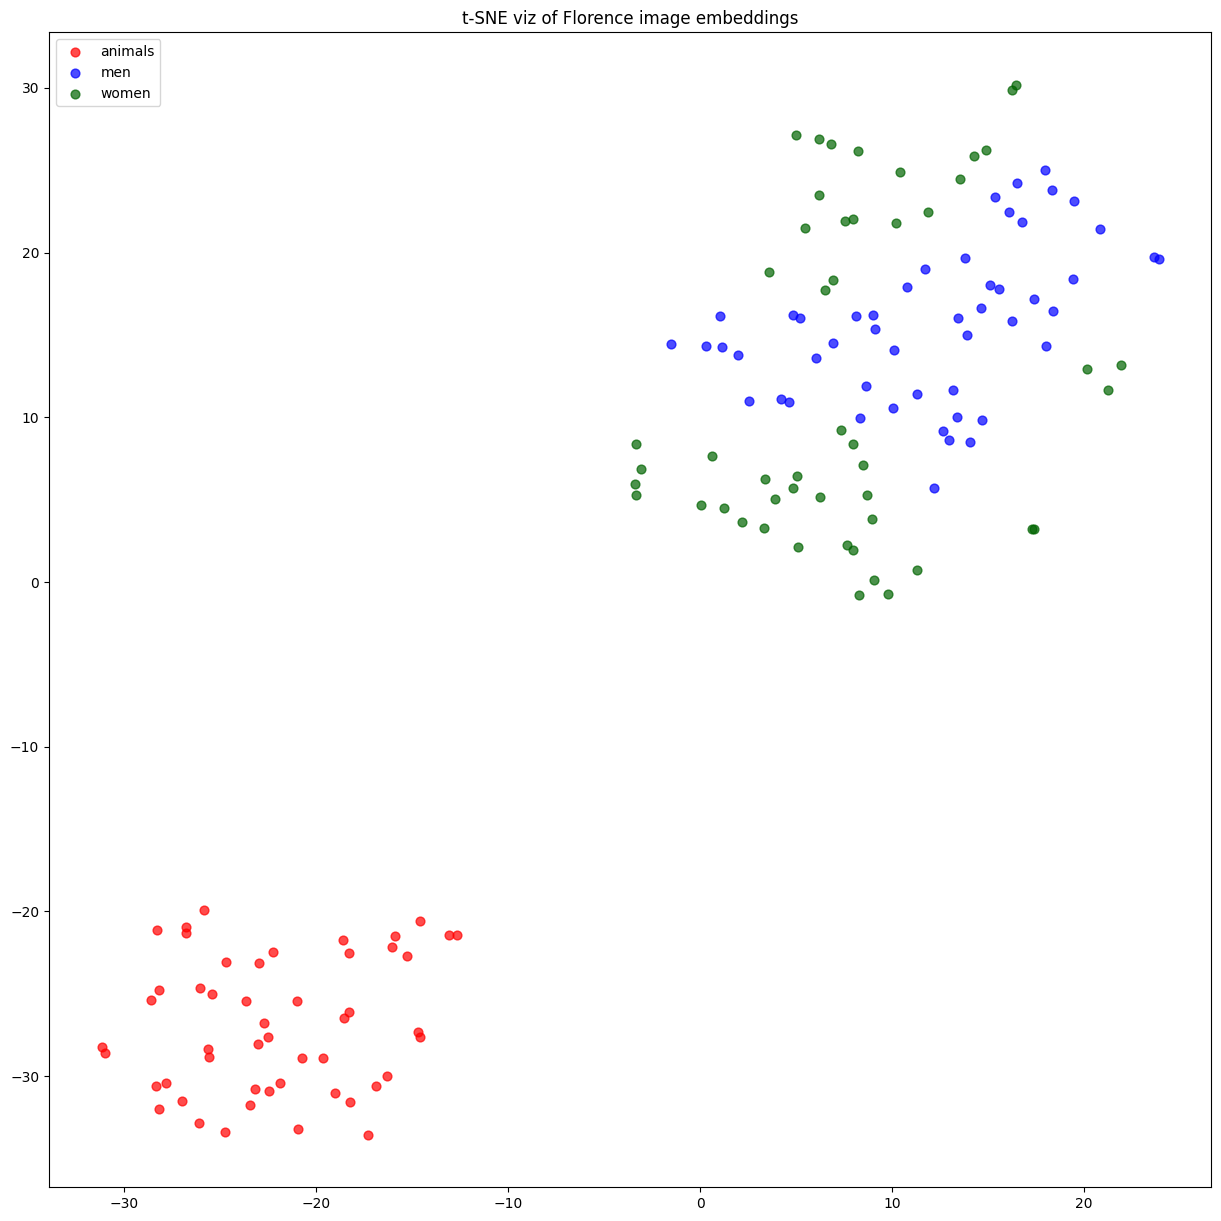

In [111]:
# plot the t-SNE embeddings
cat2col = {'women': 'darkgreen', 'men': 'blue', 'animals': 'red'}

fig,ax = plt.subplots(figsize=(15,15))
for k,d in df.groupby('class'):
    ax.scatter(d['dim1of2'], d['dim2of2'], label=k, alpha=0.7, s=40, c=cat2col[k])
plt.title('t-SNE viz of Florence image embeddings')
plt.legend(loc=2)

plt.show()

In [120]:
df['size'] = 0.8

fig = px.scatter_3d(df,
                    x='dim1of3', y='dim2of3', z='dim3of3',
                    hover_name = 'file',
                    color='class',
                    size_max = 15,
                    size='size',
                    opacity=0.0,
                    width = 1800, height = 920)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.write_html("topics.html")
fig.show()

In [47]:
df.head()

,file,class,embedding,dim1of2,dim2of2,dim1of3,dim2of3,dim3of3,size
0,./source/animals/Picture195.jpg,animals,"[-2.9765625, 0.6513672, 0.8491211, -0.72265625...",-27.835188,-30.436319,22.055460,-66.208931,-51.837227,0.8
1,./source/animals/Picture168.jpg,animals,"[-1.6015625, -2.3242188, -0.16601562, -0.05276...",-26.078140,-32.823219,91.446274,-58.382244,-66.676605,0.8
2,./source/animals/Picture160.jpg,animals,"[-0.70703125, -0.4416504, 2.6035156, -3.78125,...",-19.621000,-28.875637,7.010200,4.760835,153.743683,0.8
3,./source/animals/Picture183.jpg,animals,"[-3.1933594, 0.32128906, -2.2617188, -2.238281...",-22.455582,-30.914375,-39.599709,63.978046,157.236893,0.8
4,./source/animals/Picture189.jpg,animals,"[-4.171875, 0.59228516, -1.2441406, -0.3452148...",-24.741470,-33.387814,105.947075,-20.963415,-53.659615,0.8


,file,class,embedding,dim1of2,dim2of2,dim1of3,dim2of3,dim3of3,size,similarity
39,./source/animals/Picture201.jpg,animals,"[0.96777344, -3.4238281, 0.5786133, 0.3815918,...",-25.601475,-28.856800,-54.229362,132.151031,-105.932083,0.8,0.334614
2,./source/animals/Picture160.jpg,animals,"[-0.70703125, -0.4416504, 2.6035156, -3.78125,...",-19.621000,-28.875637,7.010200,4.760835,153.743683,0.8,0.279656
15,./source/animals/Picture166.jpg,animals,"[-2.7773438, 0.8647461, 1.8623047, -1.9423828,...",-20.755386,-28.912357,97.446068,-68.045250,42.491718,0.8,0.275476
6,./source/animals/Picture169.jpg,animals,"[-4.7617188, -0.057250977, -2.2949219, -0.1760...",-28.211105,-31.968678,72.433960,-121.664871,-19.257803,0.8,0.269393
0,./source/animals/Picture195.jpg,animals,"[-2.9765625, 0.6513672, 0.8491211, -0.72265625...",-27.835188,-30.436319,22.055460,-66.208931,-51.837227,0.8,0.266138
7,./source/animals/Picture182.jpg,animals,"[1.2822266, 0.12249756, 0.02319336, -0.2592773...",-26.036692,-24.633051,153.998947,-46.340717,61.311127,0.8,0.264736
26,./source/animals/Picture191.jpg,animals,"[-0.65966797, -0.92578125, 2.3945312, -2.24609...",-13.097449,-21.449522,0.215848,-118.017944,-77.002296,0.8,0.261594
38,./source/animals/Picture155.jpg,animals,"[-1.2724609, -0.8959961, -4.4882812, 2.4140625...",-28.282146,-21.139957,-3.232651,-118.328682,44.428112,0.8,0.258628
46,./source/animals/Picture194.jpg,animals,"[1.5703125, 1.1152344, 0.46435547, -0.07531738...",-25.401758,-25.030024,4.910240,152.423523,-85.096153,0.8,0.254946


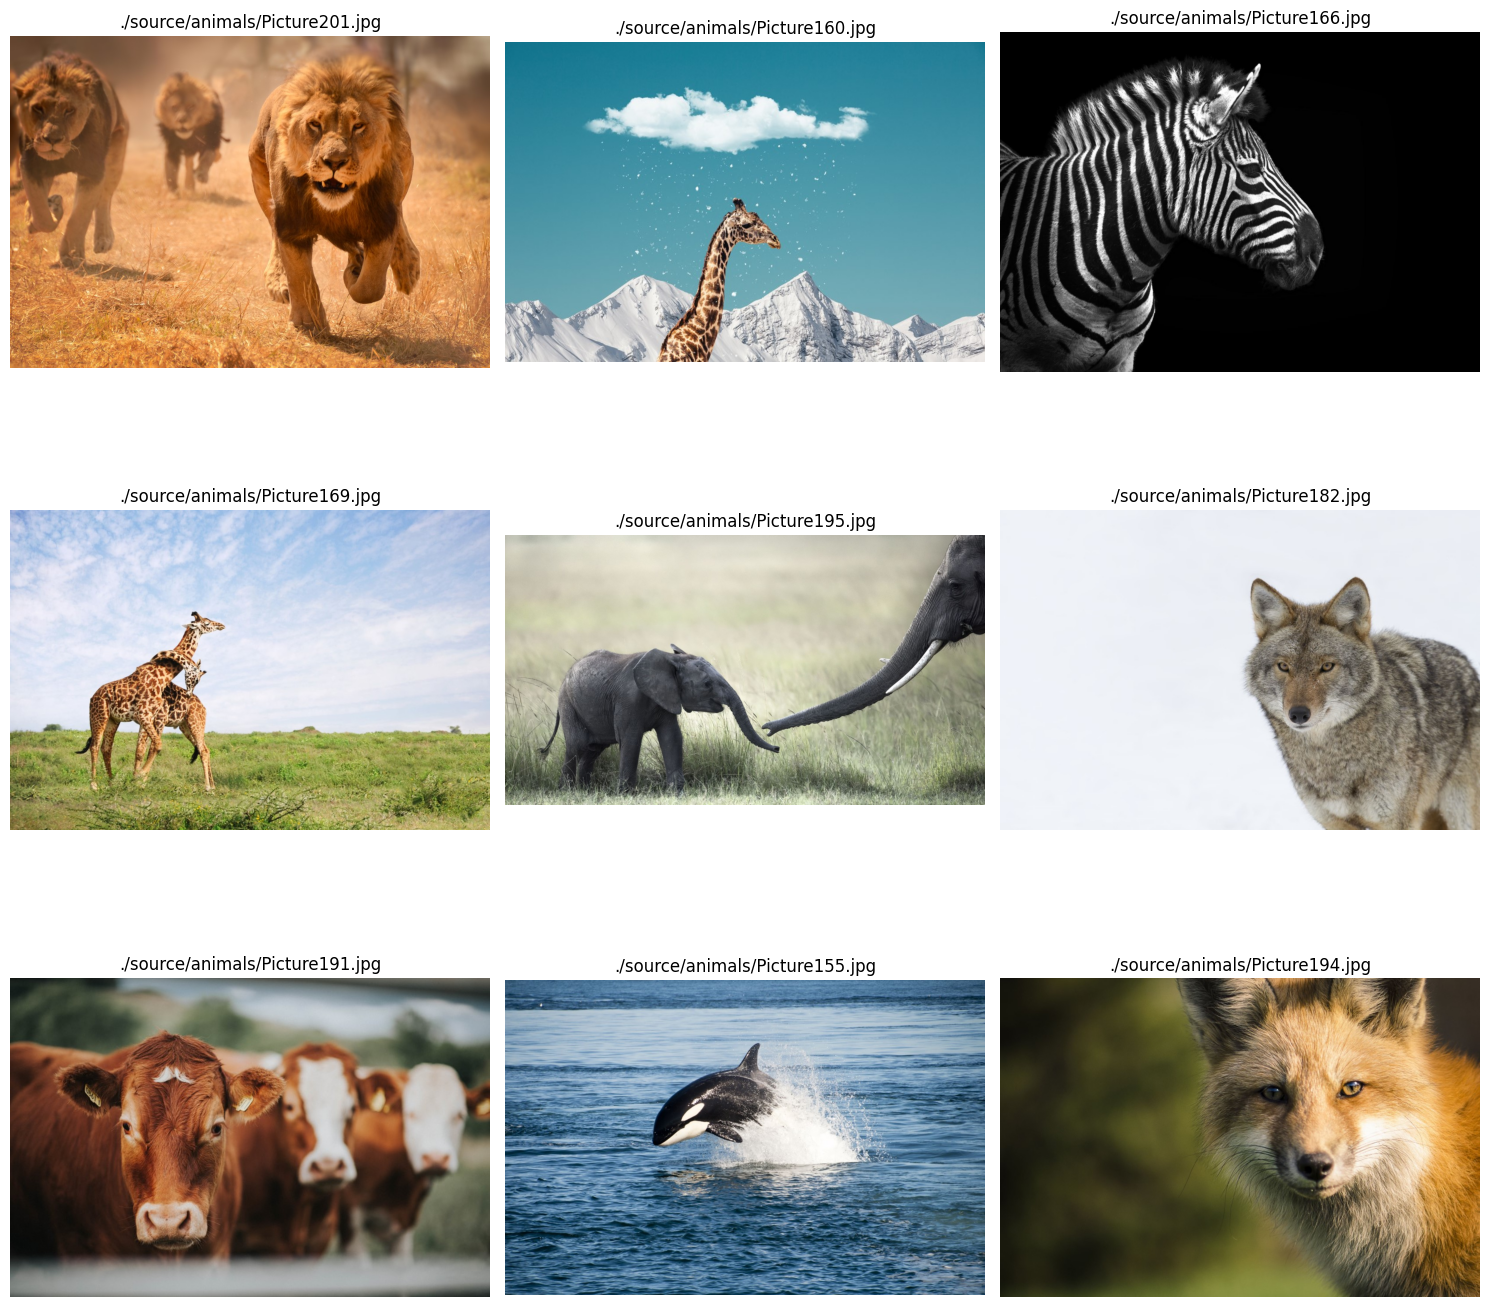

In [119]:
search_term = 'running animal'

search_vector = get_text_embedding(search_term)

df['similarity'] = df['embedding'].apply(lambda x: get_cosine_similarity(search_vector, x))

sorted_df = df.sort_values(by='similarity', ascending=False)
top_9_files = sorted_df['file'].head(9).tolist()
display(sorted_df.head(9))
show_images(images=top_9_files, cols=3, source='local')